In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import tqdm

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV, ParameterGrid


param_grid = {
    "n_components": range(1, 3),
    "covariance_type": ["tied"],
}


def get_n_components(data):
    
    res = []
    estimators = []
    for param in ParameterGrid(param_grid):
        gm = GaussianMixture(**param).fit(data)
        param['score'] = gm.bic(data)
        res.append(param)
        estimators.append(gm)
    
    df = pd.DataFrame.from_records(res)
    best_params = df[df['score']==df['score'].min()].to_dict(orient='records')[0]
    return best_params['n_components'], min(df['score'])-max(df['score'])


def run_experiment(params):
    sep, sd, sample_size, rep = params
    p1 = np.random.normal(0, sd, size=sample_size//2)
    p2 = np.random.normal(sep, sd, size=sample_size//2)
    data = np.concatenate((p1, p2))[:, np.newaxis]
    n_components, score_diff = get_n_components(data)
    
    return *params, n_components, score_diff


seps = [50]
stdevs = np.linspace(2.5, 50, 50)
sample_sizes = np.linspace(5, 250, 50).astype(int)
repeats = np.arange(100)
total = len(seps) * len(stdevs) * len(sample_sizes) * len(repeats)

res = []

params = list(itertools.product(seps, stdevs, sample_sizes, repeats))

# from multiprocessing import Pool
# with Pool(1) as p:
#     res = list(tqdm.tqdm(p.imap(run_experiment, params), total=len(params)))

res = list(tqdm.tqdm(map(run_experiment, params), total=len(params)))
# for sep, stdev, s_size in tqdm(, total=total):
#     print(sep, stdev, s_size)
#     n_components, score_diff = run_experiment(*param)
#     res.append([sep, stdev, s_size, n_components, score_diff])


/tmp/ipykernel_1680356/3298426363.py:2: RuntimeWarning: invalid value encountered in sqrt
  y = (lambda x: ((x-3)/(x-2.25))*np.sqrt((x-2)/x))(x)


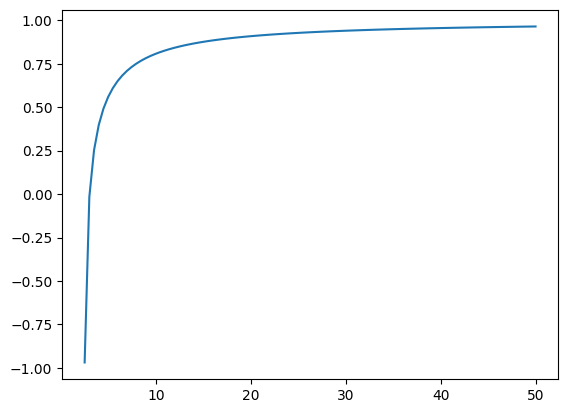

In [12]:
x = np.linspace(1, 50, 100)
y = (lambda x: ((x-3)/(x-2.25))*np.sqrt((x-2)/x))(x)

plt.plot(x,y)
     




In [ ]:
df = pd.DataFrame(res, columns=['seperation', 'stdev', 'sample_size', 'rep', 'bic_n_components', 'bic_score_diff'])


In [ ]:
df.to_csv('~/Projects/uni/phd/smlm_z/experiments/hist_experiments.csv')

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('~/Projects/uni/phd/smlm_z/experiments/hist_experiments.csv')
df = df[df['sample_size']>5]
print(df.shape)

(245000, 7)


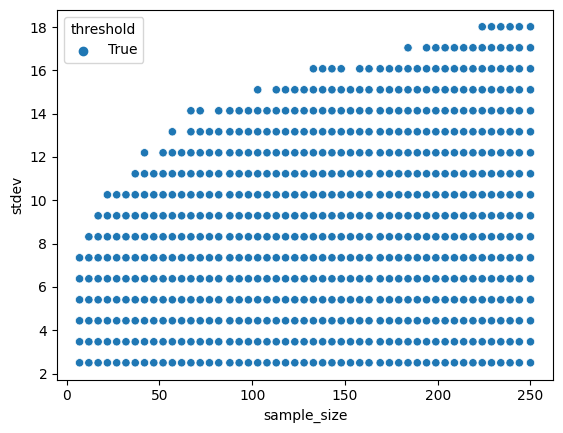

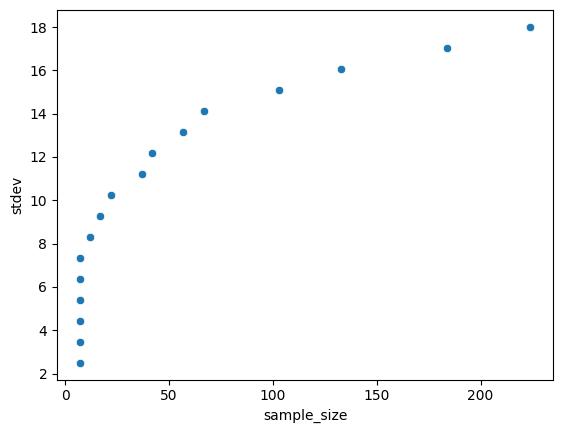

In [5]:
def count_correct(xs):
    return sum([x==2 for x in xs]) / len(xs)

threshold = 0.95
df2 = df.groupby(['sample_size', 'stdev'], as_index = False).agg([count_correct])
df2['mean_bic_n_components'] = df2['bic_n_components', 'count_correct']
df2['threshold'] = df2['mean_bic_n_components'] > threshold
df2 = df2[df2['threshold']]
sns.scatterplot(data=df2, x='sample_size', y='stdev', hue='threshold')
plt.show()

df3 = pd.DataFrame.from_records(df2.index.values, columns=['sample_size', 'stdev'])
df3 = df3.groupby('stdev').min()
sns.scatterplot(data=df3, x='sample_size', y='stdev')
plt.show()

In [ ]:
dset = df3.reset_index().to_numpy().T


In [ ]:
def model(x, a, b, c):
    return (a / np.sqrt(x + b) + c)

# def get_flipped(y_data, y_model):
#     flipped =  y_model - y_data
#     flipped[flipped < 0] = 0
#     return flipped

def resid(pars, x, y):
    """
    For every iteration, everything above the currently proposed
    curve is going to be mirrored down, so that the next iterations
    is going to progressively shift downwards.
    """
    y_model = model(x, *pars)
    resid = np.square(y - y_model)
    #print pars, resid.sum() # uncomment to check the iteration parameters
    return np.nan_to_num(resid)

# plotting the mock data
plt.plot(dset[0], dset[1], '.', alpha=0.2, label = 'Test data')

# mask bad data (we accidentaly generated some NaN values)

from scipy.optimize import leastsq
guesses =[-50, 10, 25]
fit_pars, flag = leastsq(func = resid, x0 = guesses,
                         args = (dset[0], dset[1]))


x_data = np.linspace(0, dset[0].max(), 1000)
# plot the fit:
y_fit = model(x_data, *fit_pars)
y_guess = model(x_data, *guesses)
fit_pars = [round(x, 2) for x in fit_pars]
plt.plot(x_data, y_fit, 'r-', zorder = 0.9, label = f'Edge {list(fit_pars)}')
# plt.plot(x_data, y_guess, 'g-', zorder = 0.9, label = 'Guess')
# plt.ylim((0,dset[1].max()*1.2))
plt.xlabel('Sample size')
plt.ylabel('STDev')
plt.legend(loc = 'lower left')
plt.show()


In [ ]:
def ashmans_D(x, sep=50):
    return np.sqrt(2) * (sep/np.sqrt(x**2))

x = np.logspace(1, 2, 100)
y = ashmans_D(x)
plt.xlabel('stdev')
plt.ylabel('Ashman\'s D val')
plt.plot(x,y)
plt.show()

def ashmans_D_lim(seperation):
    return (np.sqrt(2)/2) * seperation

x = np.linspace(0, 100)
y = ashmans_D_lim(x)
plt.xlabel('seperation')
plt.ylabel('Max stdev')
plt.plot(x, y)

In [ ]:
for s in sorted(set(df['sample_size'])):
    sns.stripplot(data=df[df['sample_size']==s], x='seperation', y='stdev', hue='bic_n_components')
    plt.title('Sample size ' + str(s))
    plt.ylabel('variance')
    plt.xlabel('Diff of means')
    plt.show()


In [ ]:
for x in set(df['seperation']):
    sns.scatterplot(data=df[df['seperation']==x], x='stdev', y='sample_size', hue='bic_n_components')
    plt.title(f'Seperation: {x}')
    plt.yscale('log')
    plt.show()